### We plan to compute the L2 norm as convergenc analysis:




In computational mechanics, the L2 norm (or L2 error) is a crucial tool for measuring the error between the numerical solution and the analytical solution. When performing convergence analysis, handling the L2 norm generally involves the following steps:

1. **Define the L2 Norm:**
   For a function \( u \) defined on a domain $ \Omega $, the L2 norm is defined as:
   $$
   \|u\|_{L2} = \left( \int_{\Omega} |u(x)|^2 \, dx \right)^{1/2}
   $$

2. **Compute the Error:**
   Let $u$ be the exact solution and $u_h$ be the numerical solution. The error is defined as $ e = u - u_h $. We are interested in the L2 norm of the error:
   $$
   \|e\|_{L2} = \left( \int_{\Omega} |u(x) - u_h(x)|^2 \, dx \right)^{1/2}
   $$

3. **Discretize the Error Calculation:**
   In practice, the domain $ \Omega $ is typically discretized into a finite number of elements, so the integral can be approximated using numerical integration methods (e.g., Gaussian quadrature). The discrete L2 norm of the error is calculated as:
   $$
   \|e\|_{L2} \approx \left( \sum_{i=1}^{N} w_i |u(x_i) - u_h(x_i)|^2 \right)^{1/2}
   $$
   where $ w_i $ are the numerical integration weights and $ x_i $ are the integration points.



4. **Perform Convergence Analysis:**
   To analyze the convergence of the numerical solution, we typically refine the mesh (i.e., reduce the element size \( h \)), calculate the L2 norm of the error for different mesh sizes, and observe how the L2 error changes with the mesh size. Ideally, the error should satisfy a convergence rate, such as:
   $$
   \|e\|_{L2} \leq Ch^p
   $$
   where \( C \) is a constant and \( p \) is the order of convergence.

5. **Conduct Numerical Experiments and Validation:**
   Through numerical experiments, compute the L2 error for different mesh sizes and plot the error versus mesh size on a log-log plot. In this plot, the slope of the line represents the convergence rate \( p \).

6. **Error Estimation and Theoretical Analysis:**
   Combine specific finite element theory to provide theoretical error estimates and compare these with the numerical experiment results. For example, for a second-order elliptic equation, the finite element method theoretically has an $ O(h^2) $ convergence rate in the L2 norm.


```python
# Pseudocode example for computing L2 norm error
import numpy as np

def compute_l2_error(u_exact, u_numeric, weights, points):
    error = 0.0
    for i in range(len(points)):
        error += weights[i] * (u_exact(points[i]) - u_numeric(points[i]))**2
    return np.sqrt(error)

# Assuming we have two solution functions u_exact and u_numeric, as well as integration points and weights
points = [...]
weights = [...]
u_exact = lambda x: ...  # Exact solution
u_numeric = lambda x: ...  # Numerical solution

l2_error = compute_l2_error(u_exact, u_numeric, weights, points)
print(f"L2 error: {l2_error}")
```

### We should apply Johnson(1985) solution as analytical solution, our computation is for demi-sphere and flat surface.

We would like to have a generalized Maxwell model with one pure elastic branch and one Maxwell branch. For parameter setting, we would like to have $2*G_\infty$ at t=0.

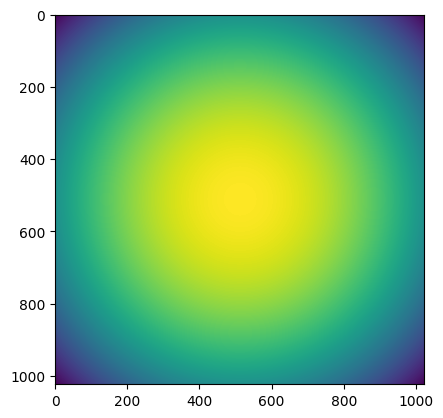

In [1]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

# parallel computation
tm.initialize(8)

# discretization
n = 1024 #[256, 512, 1024]



##load(constant)
W = 1e0  # Total load

L = 1.  # Domain size
Radius = 0.01

physical_size = [L, L]
discritization = [n, n]
model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)

model.E = 3
model.nu = 0.5

E_star = model.E / (1 - model.nu**2)

shear_modulus = [model.mu]
characteristic_time = [1] 


#We apply analytical solution in Hertz contact
surface = tm.utils.hertz_surface(physical_size, discritization,Radius)

plt.imshow(surface)

In [2]:
G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5


Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]

tau_c

G_inf: 1.0  G: [1.0]
tau: [1]  eta: [1.0]


[2.0]

#### Normalization:

$$
A_c / L^2
$$

$$
t / \tau_1
$$

$$
F_N /\left(E^* L^2 h^\prime_{\mathrm{rms}}\right)
$$

In [3]:
Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#normalized pressure
h_rms_prime = tm.Statistics2D.computeSpectralRMSSlope(surface)
'''
p_target = p_target / (E_star*h_rms_prime)
'''

Fn_Johnson = W / (E_star*h_rms_prime)

#solver.solve(p_target)
time_steps_list = np.geomspace(4,800,10 , dtype=int)#[2, 20, 30, 50, 80, 100, 150, 250, 400, 800, 1200, 1600]
#L2_norms = []
error_list = []

##time
t0 = 0
t1 = 10 
## normalized time
t0 = 0/np.min(characteristic_time)
t1 = 10/np.min(characteristic_time)



In [4]:
##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

 Iter          Cost_f           Error


    0    3.812016e-02    5.307948e-01
  100    3.300610e-01    5.173247e-11
  126    1.002823e+00    8.867830e-13
 Iter          Cost_f           Error
    0    5.350429e-01    1.071732e-02
  100    5.243785e-01    6.805831e-12
  113    1.258171e+00    6.935513e-13
 Iter          Cost_f           Error
    0    6.009912e-01    3.946620e-03
  100    5.992164e-01    2.175000e-12
  103    1.358877e+00    9.253964e-13
 Iter          Cost_f           Error
    0    6.292288e-01    1.373316e-03
  100    6.289876e-01    1.024127e-12
  102    1.399921e+00    5.643632e-13


[np.float64(0.040436744689941406), np.float64(0.044548988342285156), np.float64(0.04636096954345703)]
[np.float64(0.04309094174405238), np.float64(0.04645334168481716), np.float64(0.04739428799215573)]
3
3


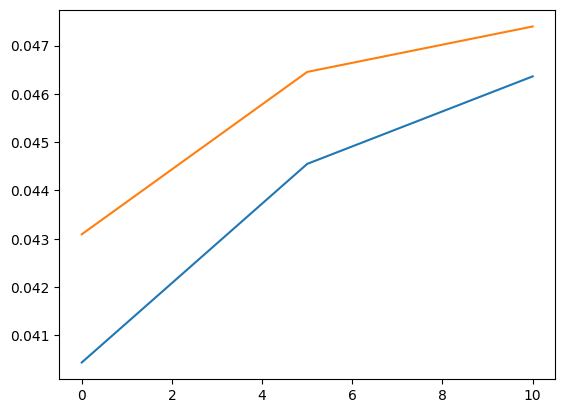

 Iter          Cost_f           Error
    0    3.152036e-01    1.319296e-02
  100    3.405714e-01    1.005561e-11
  113    1.039436e+00    8.720525e-13
 Iter          Cost_f           Error


In [5]:

for time_steps in time_steps_list:
    dt = (t1 - t0) / time_steps
    Ac_tamaas = []
    Ac_Johnson_ref = []
    # Solver
    solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)
    solver.reset()

    for i in range(time_steps):
        solver.solve(p_target)
        contact_area_result = np.mean(model.traction > 0) * L**2
        normalized_result = contact_area_result / L**2      ######normalized contact area
        Ac_tamaas.append(normalized_result)

    for t in np.arange(t0, t1, dt):        
        Ac_Johnson_ref.append((3 / 8 * Radius * W * (1 / g_1 + 1 / g_2 * (1 - np.exp(-t / tau_c[0]))))**(2/3) * np.pi)


    Ac_tamaas = Ac_tamaas[:-1]
    Ac_Johnson_ref = Ac_Johnson_ref[1:]

    print(Ac_tamaas)
    print(Ac_Johnson_ref)
    print(len(Ac_tamaas))
    print(len(Ac_Johnson_ref))

    '''
    # Calculate L2 norm between Ac_tamaas and Ac_Johnson_ref
    L2_error = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))

    # normalize L2 error
    L2_error /= np.sqrt(len(Ac_tamaas))   
    '''
    #L2_error = np.linalg.norm(np.array(Ac_tamaas) - np.array(Ac_Johnson_ref)) / np.sqrt(len(Ac_tamaas))
    L2_norm = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))
    error = L2_norm / np.linalg.norm(Ac_Johnson_ref) 
    error_list.append(error)
    #L2_norms.append(L2_error)
    plt.plot(np.linspace(t0, t1, time_steps-1), Ac_tamaas, label='Tamaas')
    plt.plot(np.linspace(t0, t1, time_steps-1), Ac_Johnson_ref, label='Johnson')
    plt.show()


In [ ]:
print(error_list)

[np.float64(0.04124937278541024), np.float64(0.025249014146563862), np.float64(0.014008263128913912), np.float64(0.007235517637277546), np.float64(0.0032881648626548188), np.float64(0.0016681721616153753), np.float64(0.0013611143402834471), np.float64(0.0016492777763589075), np.float64(0.0018895482217006392), np.float64(0.0020388313404353224)]


[np.float64(2.5), np.float64(1.4285714285714286), np.float64(0.8333333333333334), np.float64(0.43478260869565216), np.float64(0.23809523809523808), np.float64(0.13333333333333333), np.float64(0.07352941176470588), np.float64(0.04065040650406504), np.float64(0.02252252252252252), np.float64(0.0125)]


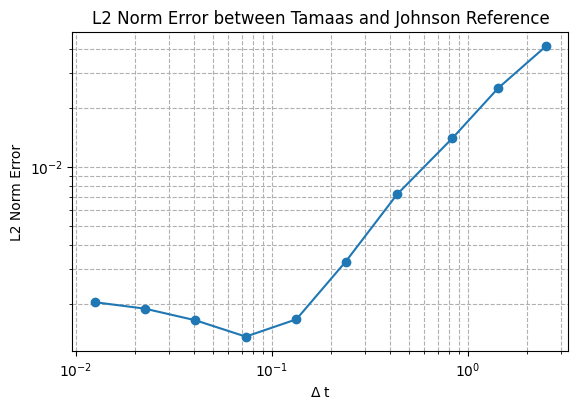

In [ ]:
dt_list = [(t1 - t0) / time_steps for time_steps in time_steps_list]
print(dt_list)
# Plot log-log graph of L2 norms
plt.figure()
plt.loglog(dt_list, error_list, marker='o')
plt.xlabel('$\Delta$ t')
plt.ylabel('L2 Norm Error')
plt.title('L2 Norm Error between Tamaas and Johnson Reference')
plt.grid(True, which="both", ls="--")
plt.gca().set_aspect('equal')
plt.show()